<a href="https://colab.research.google.com/github/foxtrotmike/LWR/blob/master/xor2_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


AUC without rejection= 0.9526749999999999
AUC with rejection= 0.977219243890552
Number of examples rejected= 392 / 2000


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:170: UserWarning: The following kwargs were not used by contour: 'label'


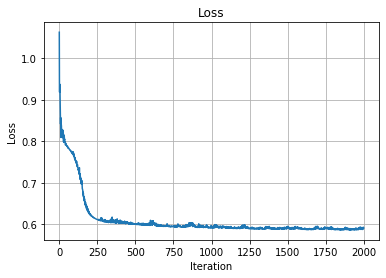

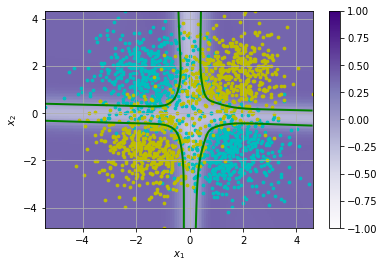

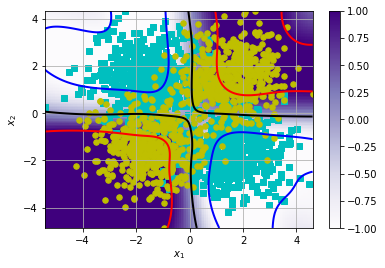

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 13 00:50:45 2019

@author: Amina Asif
"""

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from sklearn.metrics import roc_auc_score as auc_roc



import itertools
import warnings

import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,**kwargs):
    """
    @author: Dr. Fayyaz Minhas
    @author-email: afsar at pieas dot edu dot pk
    2D Scatter Plotter for Classification
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours   
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)        
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
        
    d0,d1 = (0,1)
    minx, maxx = np.min(X[:,d0]), np.max(X[:,d0])
    miny, maxy = np.min(X[:,d1]), np.max(X[:,d1])
    eps=1e-6

    
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None:
            conts = list(classes)        
        vmin,vmax = classes[0]-eps,classes[-1]+eps
    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None:            
            conts = sorted([-1+eps,0,1-eps])
        
    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        t=Variable(torch.from_numpy(t)).type(torch.FloatTensor)
        z = clf(t,**kwargs)
        
        z = np.reshape(z.numpy(),(npts,npts)).T        
        extent = [minx,maxx,miny,maxy]
        
        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis([minx,maxx,miny,maxy])
    
    if Y is not None:        
        for i,y in enumerate(classes):
            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]
            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 30)     
         
    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')   
    if not hold:
        plt.grid()        
        plt.show()



def loss_rej(y, h, r=1, c=0):
    if type(r)!=type(1):
        r=np.array(r)
    l_total=np.mean(np.sum(((y*h)<=0)*(r>0)+c*(r<=0)))
    l_rejection=np.mean(np.sum(c*(r<=0)))
    return l_total, l_rejection

def hinge(y_true, y_pred):
    zero = torch.Tensor([0]) 
#    import pdb; pdb.set_trace()
#    return torch.mean(torch.max(zero, 1 - y_true * y_pred))
    return torch.max(zero, 1 - y_true * y_pred)


class Net(nn.Module):
    def __init__(self,d):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(d,10)  
#        self.hidden2 = nn.Linear(10,10)  
        self.out = nn.Linear(10,1)

    def forward(self,x):
#        x = x.view(x.size(0), -1)
        x = self.hidden1(x)
        x = F.tanh(x)
#        x = self.hidden2(x)
#        x = F.tanh(x)
        
        x = self.out(x)
#        x = F.tanh(x)
        return x



class RejNet(nn.Module):
    def __init__(self,d):
        super(RejNet, self).__init__()
        self.hidden1 = nn.Linear(d,10)  
        self.hidden2 = nn.Linear(10,100)  
        self.out = nn.Linear(100,1)

    def forward(self,x):
#        x = x.view(x.size(0), -1)
        x = self.hidden1(x)
        x = F.tanh(x)
        x = self.hidden2(x)
        x = F.tanh(x)
        
        x = self.out(x)
        x = F.tanh(x)
        return x


###################Generate Data######################
d=1.50
n=500
X1=np.random.randn(n,2)+d*np.array([1,1])
l1=[1.0]*len(X1)

X2=np.random.randn(n,2)+d*np.array([1,-1])
l2=[-1.0]*len(X2)

X3=np.random.randn(n,2)+d*np.array([-1,1])
l3=[-1.0]*len(X3)


X4=np.random.randn(n,2)+d*np.array([-1,-1])
l4=[1.0]*len(X4)



data=np.vstack((X1, X2, X3, X4))
labels=np.array(l1+l2+l3+l4)

pos=np.vstack((X1,X4))
neg=np.vstack((X2,X3))
#plt.scatter(pos[:,0], pos[:,1])
#plt.scatter(neg[:,0], neg[:,1])


Xtr=Variable(torch.from_numpy(data)).type(torch.FloatTensor)

Ytr=Variable(torch.from_numpy(labels)).type(torch.FloatTensor)

############## Train classifier#########################

class_epochs=2000
mlp_class=Net(Xtr.shape[1])
optimizer = optim.Adam(mlp_class.parameters(), lr=0.01)

zero=np.zeros(Ytr.shape)
zero=Variable(torch.from_numpy(zero)).type(torch.FloatTensor)

mlp_rej=RejNet(Xtr.shape[1])
optimizer_rej = optim.Adam(mlp_rej.parameters(), lr=0.01)
c=0.650




L=[]

for epoch in range(class_epochs):
            # Forward pass: Compute predicted y by passing x to the model
    y_pred = mlp_class(Xtr)

    
    h = torch.squeeze(mlp_class(Xtr),1)
    r=torch.squeeze(mlp_rej(Xtr),1)
    e = hinge(Ytr,h)
    
    l1 = torch.max(r+e,c*(1-r))
  

    loss_r=torch.mean(torch.max(zero, l1 ))    
  
    L.append(loss_r.data.numpy())

    optimizer.zero_grad()

    optimizer_rej.zero_grad()
    loss_r.backward()
    optimizer.step()
    optimizer_rej.step()
    
plt.close('all')
plt.plot(L)
plt.title('Loss')
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss')    
    
for param in mlp_class.parameters():
    param.requires_grad =False
        
for param in mlp_rej.parameters():
    param.requires_grad =False
     

    
X=Xtr
Y=Ytr

y_p= mlp_class(X)
y_p=y_p.detach()
y_r=mlp_rej(X)
y_r=y_r.detach()
y_r=y_r.numpy().flatten()
y_p2=y_p.numpy().flatten()
Y=np.array(Y)
auc_c=auc_roc(Y, y_p2)
auc_r=auc_roc(Y[y_r>0], y_p2[y_r>0])

print("AUC without rejection=", auc_c)
print("AUC with rejection=", auc_r)

print ("Number of examples rejected=", len(y_r[y_r<0]), "/", len(y_r))


#plt.close('all')
plt.figure()
X2=np.array(X)
plotit(X2,Y,clf=mlp_rej, transform = None, conts =[0], ccolors = ['g'], markers = ('.','.') )
plt.figure()
plotit(X2,Y,clf=mlp_class, transform = None, conts =[-1,0,1])
